In [1]:
## Module Import

import numpy as np  
import matplotlib.pyplot as plt
import torch # deep learning framework pytorch
import torch.nn as nn # module including functions needed for deep learning/ai
import torch.nn.functional as F 
from torchvision import transforms, datasets

In [2]:
## Identify device used for Deep Learning module

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)

Using PyTorch version: 1.7.1 Device: cpu


In [3]:
BATCH_SIZE = 32 #모델 학습시 필요한 데이터 
EPOCHS = 10 # batch 개 단위로 back propaagation을 이용해 MLP weight 업데이트 
# hyperparameters usually capitalized

In [4]:
## MNIST 데이터 다운로드 

train_dataset = datasets.MNIST(root = "data/MNIST", #root: 데이터가 저장될 장소 지정
                               train = True, #대상 데이터가 학습용
                               download = True, #해당 데이터 인터넷에서 다운로드 
                               transform = transforms.ToTensor()) #손글씨 '이미지'데이터 불러옴과 함께 전처리
                               #tensor 형태로 데이터 불러옴, 0~255 범위의 픽셀 값 0~1 범위로 정규화
test_dataset = datasets.MNIST(root = "data/MNIST", 
                              train = False, #대상 데이터가 검증용
                              transform = transforms.ToTensor())
#정규화해 불러온 train, test 데이터셋 mini-batch 단위로 분리해 지지정
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) #데이터 순서 섞기
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz
 94%|█████████▎| 9281536/9912422 [00:03<00:00, 3772644.86it/s]Extracting data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\MNIST\raw

9920512it [00:03, 2831734.92it/s]                             Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]Extracting data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\MNIST\raw
 79%|███████▉  | 1302528/1648877 [00:01<00:00, 985475.76it/s]

0it [00:00, ?it/s]Extracting data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\MNIST\raw


  0%|          | 0/4542 [00:00<?, ?it/s]Extracting data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\MNIST\raw
Processing...
Done!
1654784it [00:15, 985475.76it/s]                             

In [8]:
## 데이터 확인하기 -> 다운로드 한 후 mini-batch 단위로 할당한 데이터의 개수, 형태 확인

for (X_train, y_train)in train_loader:
    print('X_train:', X_train.size(), 'type: ', X_train.type())
    print('Y_train:', y_train.size(), 'type: ', y_train.type())
    break

# X_train: torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor 
# --> 32개의 데이터로 batch 구성, 채널 1(그레이스케일), 28x28픽셀의 이미지
# Y_train: torch.Size([32]) type:  torch.LongTensor
# --> 32개의 이미지 데이터 각각에 label값 1개씩 존재, 32개의 값

X_train: torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
Y_train: torch.Size([32]) type:  torch.LongTensor


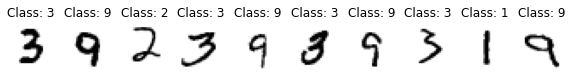

In [12]:
## 데이터 확인하기

pltsize = 1
plt.figure(figsize = (10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = "gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [13]:
## MLP(Multi Layer Perceptron) 모델 설계

class Net(nn.Module):   #PyTorch Moudle 내 딥러닝 모델 관련 기본 함수 포함하는 nn.Module 클래스 상속받는 Net 클래스 정의
    def __init__(self): #Net 클래스의 instance 생성시 지니게 되는 성질 정의
        super(Net, self).__init__() #nn.Module 내의 메서드 상속받아 이용 
        self.fc1 = nn.Linear(28*28, 512)    #첫 번째 Fully Connected Layer 정의, input size: 28*28*1, output node 수: 512
        self.fc2 = nn.Linear(512, 256)      #두 번째 Fully Connected Layer 정의, input: 512, output: 256 
        self.fc3 = nn.Linear(256, 10)       #세 번째 Fully Connected Layer 정의, input: 256, output: 10 (0~9까지 10개의 클래스 표현 위한 라벨 one-hot-encoding)

    def forward(self, x):   #clss Net 이용해 설계한 MLP 모델의 Forward Propagation정의 -> output 계산하기까지 과정 나열
        x = x.view(-1, 28*28)   #2차원 데이터 1차원 데이터로 변형, view 메서드 사용 - 784크기의 1차원 데이터로 변환(flatten)
        x = self.fc1(x)     #첫 번째 Fully Connected Layer에 1차원으로 펼친 이미지 데이터 통과
        x = F.sigmoid(x)    #torch.nn.functional 에 정의된 비선형 함수 sigmoid() 이용해 fc2의 input 계산
        x = self.fc2(x)     #두 번째 Fully Connected Layer에서 sigmoid() 함수로 계산된 결과값 통과
        x = F.sigmoid(x)    #torch.nn.functional 에 정의된 sigmoid() 이용해 fc3의 input 값 계산
        x = self.fc3(x)     #세 번째 Fully Connected Layer에서 sigmoid() 함수로 계산된 결과값 통과
        x = F.log_softmax(x, dim = 1)   #torch.nn.functional 내의 log_softmax 이용해 최종 output 계산
        #softmax 이용해 0~9까지 10개의 클래스에 속할 확률 값 계산 
        #log_softmax -> 일반적인 softmax 보다 Back Propagation 이용해 학습시 loss 값에 대한 gradient값 보다 원활하게 계산(log 함수의 기울기 보다 부드럽게 변화)
        
        return x    #최종 계산된 x 값 output으로 반환




In [15]:
## Optimizer, Objective Function 설정하기

model = Net().to(DEVICE)    #앞서 정의한 모델을 DEVICE에 할당
#Back Propagation 이용해 파라미터 업데이트시 이용하는 optimizer 정의
#Stochastic Gradient Descent(SGD) 알고리즘 이용, Learning Rate 0.01, Momentum(Optimizer의 관성 나타냄) 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)  

#MLP 모델의 output 값 + one-hot-encoding값과의 loss Criterion 이용해 계산 
criterion = nn.CrossEntropyLoss()   #nn.CrossEntropyLoss() 로 criterion 설정

print(model)


# Net(
#   (fc1): Linear(in_features=784, out_features=512, bias=True)
#   (fc2): Linear(in_features=512, out_features=256, bias=True)
#   (fc3): Linear(in_features=256, out_features=10, bias=True)
# )

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [25]:
## MLP 모델 학습 진행, 학습 데이터에 대한 모델 성능 확인

def train(model, train_loader, optimizer, log_interval):
    model.train()   #MLP 모델을 학습 상대로 지정
    for batch_idx,(image, label) in enumerate(train_loader):    #train_loader: 이미지+레이블 데이터 batch로 묶여서 저장
                                                                #train_loader의 batch별로 저장된 데이터 순서대로 이용해 MLP 모델 학습시킴
        image = image.to(DEVICE)    #mini-batch의 이미지 데이터 활용하기 위해 device에 할당
        label = label.to(DEVICE)    #mini-batch의 레이블 데이터도 device에 할당
        optimizer.zero_grad()       #기존의 device에 할당할 경우 과거에 이용한 데이터를 바탕으로 계산된 loss와 gradient값이 optimizer에 할당되어 있으므로 optimizer의 gradient값을 초기화
        output = model(image)       #장비에 할당한 이미지 데이터를 MLP 모델의 input으로 output계산
        loss = criterion(output, label) #계산된 output을 label값과 함께 기존에 정의한 cross entropy를 이용해 loss 계산
        loss.backward()     #loss계산값을 바탕으로 back propagation -> 계산된 gradient 값 각 parameter에 할당
        optimizer.step()    #각 파라미터에 할당된 graidient값을 이용해 파라미터 값 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\t Train Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. *batch_idx / len(train_loader),
                loss.item()
            ))

In [21]:
## 학습되는 과정 중 검증 데이터에 대한 모델 성능을 확인

def evaluate(model, test_loader):
    model.eval()    #학습 과정, 학습 완료된 MLP 모델을 학습 상태가 아닌, 평가 상태로 지정
    test_loss = 0   #test_loader 데이터를 이용해 loss 값 계산 위해 test_loss 0으로 임시설정
    correct = 0     #학습 완료된 MLP 모델이 올바른 Class로 분류한 경우 세기 위한 변수

    with torch.no_grad():   #torch.no_grad(): 모델 평가하는 단계에서 gradient통해 파라미터 값이 업데이트 되는 현상을 방지 
        for image, label in test_loader:    #test_loader batch 단위로 저장 -> for 문으로 차례대로 접근
            image = image.to(DEVICE)    #test_loader의 mini-batch내의 데이터 device에 할당
            label = label.to(DEVICE)    #test_loader의 label 데이터 device에 할당
            output = model(image)       #MLP 모델 output계산
            test_loss += criterion(output, label).item()    #output과 label 값에 대해 CrossEntropy를 이용해 loss 계산-> test_loss 업데이트 
            prediction = output.max(1, keepdim = True)[1]   #MLP 모델의 output -> 크기 10인 벡터값
                                                            #계산된 벡터 값 내 가장 큰 값의 위치에 해당하는 클래스 예측
            correct += prediction.eq(label.view_as(prediction)).sum().item()    #예측값 == label값일 때 correct 변수 1 증가(올바르게 예측한 횟수)
    
    test_loss /= len(test_loader.dataset)   #현재까지의 test_loss를 batch 개수만큼 나누어 평균 loss 값 구함
    test_accuracy = 100. *correct / len(test_loader.dataset)    #test_loader 데이터 중 얼마나 맞추었는지 정확도 계산
    return test_loss, test_accuracy  



In [26]:
## MLP 학습 -> Train, Test set의 Loss 및 Test Set Accuracy 확인

for Epoch in range (1, EPOCHS +1 ):
    train(model, train_loader, optimizer, log_interval = 200)   #train_loaer 학습데이터로 train model 실행, log_interval: 학습 과정 출력
    test_loss, test_accuracy = evaluate(model, test_loader) #각 epoch별로 출력되는 loss 값과 accuracy 계산
    print("\n[Epoch: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	 Train Loss: 2.412143
Train Epoch: 1 [6400/60000(11%)]	 Train Loss: 2.305974
Train Epoch: 1 [12800/60000(21%)]	 Train Loss: 2.282718
Train Epoch: 1 [19200/60000(32%)]	 Train Loss: 2.317387
Train Epoch: 1 [25600/60000(43%)]	 Train Loss: 2.291491
Train Epoch: 1 [32000/60000(53%)]	 Train Loss: 2.289565
Train Epoch: 1 [38400/60000(64%)]	 Train Loss: 2.289675
Train Epoch: 1 [44800/60000(75%)]	 Train Loss: 2.270282
Train Epoch: 1 [51200/60000(85%)]	 Train Loss: 2.292913
Train Epoch: 1 [57600/60000(96%)]	 Train Loss: 2.213113

[Epoch: 1], 	 Test Loss: 0.0699, 	 Test Accuracy: 29.45 %

Train Epoch: 2 [0/60000(0%)]	 Train Loss: 2.223816
Train Epoch: 2 [6400/60000(11%)]	 Train Loss: 2.192035
Train Epoch: 2 [12800/60000(21%)]	 Train Loss: 2.177076
Train Epoch: 2 [19200/60000(32%)]	 Train Loss: 2.102854
Train Epoch: 2 [25600/60000(43%)]	 Train Loss: 1.925077
Train Epoch: 2 [32000/60000(53%)]	 Train Loss: 1.805249
Train Epoch: 2 [38400/60000(64%)]	 Train Loss: 1.805819
